In [31]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [32]:
import pandas as pd

In [37]:
import glob
directory = "/data/MCMC/"
files = sorted( glob.glob(directory + "par*.bin"), 
                key=lambda x:int(x.split("/")[-1][3:].split('_')[0]))
bins = []
for line in open("/data/MCMC/metadata.txt","r"):
    tag = line.split()[0].split("_")
    if tag[0] == "bin": bins.append(float(line.split()[1]))
bins = np.array(bins)

In [50]:
import struct

data = {}
for fname in files:
    with open(fname, "rb") as f: 
        size = int(struct.unpack('<i', f.read(4))[0])
        data[fname] = np.fromfile(f,np.float32)
data = pd.DataFrame(data)[files]
dataP = data.iloc[:,:len(data.columns)/2]
dataP.columns = bins[:-1]
dataD = data.iloc[:,len(data.columns)/2:]
dataD.columns = bins[:-1]

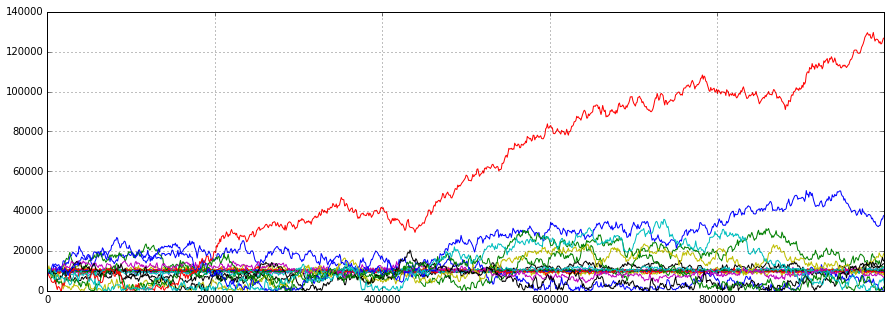

In [47]:
figsize(15,5)
data.iloc[::1000].plot(legend=False)

(0, 40000)

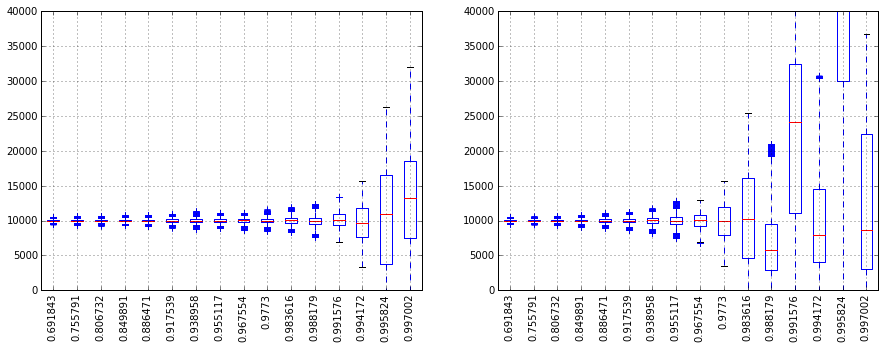

In [54]:
figsize(15, 5)
subplot(121)
dataP.boxplot();
xticks(rotation='vertical')
ylim(0,40000)
subplot(122)
dataD.boxplot();
xticks(rotation='vertical')
ylim(0,40000)